In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

from scipy.io import loadmat

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
meg_data = pd.read_csv("MEG_art", header=None, sep="  ").to_numpy()

/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [51]:
N_total = meg_data.shape[1]
N_train = int(0.8 * N_total)
N_test = N_total - N_train
n_channels = 10
dim = n_channels ** 2

In [140]:
X_train = meg_data[:n_channels, :N_train].T
X_test = meg_data[:n_channels, N_train:].T

X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

std, mu = torch.std_mean(X_train, 0)

X_train = (X_train - mu) / std
X_test = (X_test - mu) /std

In [145]:
sigma2 = 1.0

def log_prior(W):
    return - torch.sum(W**2) / (2 * sigma2)

def log_likelihood(x, W):
    W = W.view(n_channels, n_channels)
    return x.shape[0] * torch.log(torch.abs(torch.det(W))) - 2 * torch.sum(torch.log(torch.cosh(x @ W)))

def log_posterior(x, W):
    return log_prior(W) + (N_train / x.shape[0]) * log_likelihood(x, W)

def log_posterior_batch(x, W_batch):
    func = lambda W: log_posterior(x, W)
    func = torch.vmap(func)
    return func(W_batch)

In [75]:
class SDE(torch.nn.Module):
    
    def __init__(self, gamma, input_dim, width=300):
        super().__init__()
        activation = torch.nn.Softplus
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim)
        )
        
        self.nn[-1].weight.data.fill_(0)
        self.nn[-1].bias.data.fill_(0)
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        self.gamma = gamma
    
    def f(self, t, params_batch):
        t_ = t * torch.ones((params_batch.shape[0], 1), device=params_batch.device)
        return self.nn(torch.cat((t_, params_batch), dim=-1))
    
    def g(self, t, params_batch):
        return torch.sqrt(self.gamma * torch.ones_like(params_batch))

In [146]:
def loss(sde, x, dt=0.05):
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    param_init = torch.zeros((param_batch_size, dim), device=device)
    param_trajectory = torchsde.sdeint(sde, param_init, ts, method="euler", dt=dt)
    param_T = param_trajectory[-1]
    
    fs = torch.vmap(sde.f)(ts, param_trajectory)
    
    energy_cost = torch.sum(fs**2, dim=[0, 2]) * dt  / (2 * gamma)
    
    terminal_cost = - torch.sum(param_T**2, dim=1) / (2 * gamma) - log_posterior_batch(x, param_T)
    
    return torch.mean(energy_cost + terminal_cost) / N_train

In [172]:
gamma = 0.01**2
sde = SDE(gamma, dim).to(device)

optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)

n_epochs = 2
data_batch_size = 10
param_batch_size = 32

In [173]:
losses = []

for _ in range(n_epochs):
    epoch_losses = []
    
    perm = torch.randperm(N_train)
    X_train = X_train[perm]
    
    for i in tqdm(range(0, N_train, data_batch_size)):
        x = X_train[i:min(i + data_batch_size, N_train)]
        
        optimizer.zero_grad()
        l = loss(sde, x, dt=0.05)
        l.backward()
        epoch_losses.append(l.detach().cpu().numpy())
        optimizer.step()
        
    losses.append(epoch_losses)

  0%|                                                                       | 0/1419 [00:00<?, ?it/s]/tmp/ipykernel_405078/3846770037.py:9: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  fs = torch.vmap(sde.f)(ts, param_trajectory)
/tmp/ipykernel_405078/4129360332.py:15: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|██████████████████████████████████████████

In [174]:
losses = np.array(losses)

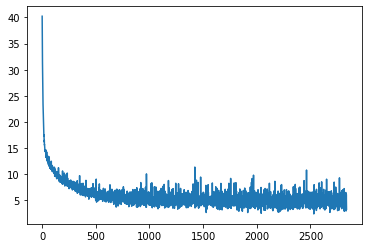

In [175]:
plt.plot(losses.flatten())

In [176]:
with torch.no_grad():
    dt = 0.005
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    W_init = torch.zeros((100, dim), device=device)
    W_trajectory = torchsde.sdeint(sde, W_init, ts, method="euler", dt=dt)
    W_samples = W_trajectory[-1]

In [177]:
with torch.no_grad():
    logps = log_posterior_batch(X_test, W_samples)

/tmp/ipykernel_405078/4129360332.py:15: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


In [180]:
torch.mean(logps) / N_test

tensor(-19.7106, device='cuda:0')

In [181]:
@torch.enable_grad()
def gradient(x, W):
    W_ = W.clone().requires_grad_(True)
    loss = log_posterior(x, W_)
    grad, = torch.autograd.grad(loss, W_)
    return loss.detach().cpu().numpy(), grad

In [207]:
def step_size(n):
    return 0.0001 / (1 + n)**0.5

In [208]:
W = torch.randn(dim).float().to(device)
n_epochs = 10

In [209]:
step = 0

losses = []
logps = []

for _ in range(n_epochs):
    perm = torch.randperm(N_train)
    X_train = X_train[perm]
    
    for i in tqdm(range(0, N_train, data_batch_size)):
        x = X_train[i:min(i + data_batch_size, N_train)]
        
        eps = step_size(step)
        loss, grad = gradient(x, W)
        W = W + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(W)
        step += 1
        losses.append(epoch_losses)
        
        with torch.no_grad():
            logp = log_posterior(X_test, W) / N_test
            logps.append(logp.cpu().numpy())

100%|██████████████████████████████████████████████████████████| 1419/1419 [00:01<00:00, 1012.48it/s]


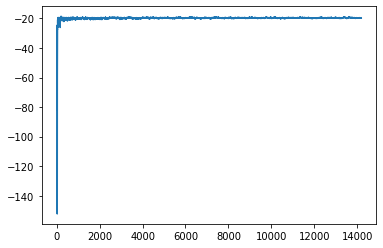

In [210]:
plt.plot(logps)